In [1]:
# !pip install base45==0.4.1
# !pip install cbor2==5.4.1
# !pip install cose==0.9.dev8
# !pip install cryptography==3.4.7
# !pip install cryptojwt==1.5.2
#!pip install qrcode[pil]

In [1]:
import cbor2
from cose.algorithms import Es256
import json
from api import MysejahteraPrivateAPI
import copy

### Mysejahtera Private API

I only pulled the Digital Certificate part of the API

In [2]:
# copy the credentials.example.json to credentials.json and fill-up the username and password
with open("credentials.json", "r") as f:
    cred = f.read()
cred = json.loads(cred)
username = cred['username']
password = cred['password']

In [3]:
mysejahteraPrivateAPI = MysejahteraPrivateAPI(username,password)

In [4]:
mysejahteraPrivateAPI.login()

In [5]:
cert_data = mysejahteraPrivateAPI.digital_cert()

In [6]:
tmp = copy.deepcopy(cert_data)
# truncate to cencor my info
tmp['data']['DOSE1'] = tmp['data']['DOSE1'][0:100] + ".." + cert_data['data']['DOSE1'][-30:-1]

### Payload Structure

I haven't fully understand the structure yet since mine only showing first dose information at the moment

In [7]:
tmp

{'errorMessage': None,
 'message': None,
 'errorMessages': [],
 'data': {'DOSE1': 'HC1:NCFA 9VAQZVQUS37%HVU0 T2+-5RJF1 BNOLVWTEJM-OAM56**I4$6/UK9IMR3QX+48YI41LDTQZZ30B2SQH./1TNMH6U40A..4KTRBRNHJ10P6/I4OB1BS AWV3613'},
 'success': True}

In [8]:
dose_1 = cert_data['data']['DOSE1']

### Decoding the message

* The string payload is a Base45-encoded data and compressed with zlib
* The actual object of the payload is a CBOR

In [10]:
cose_msg = MysejahteraPrivateAPI.decode_vaccine_cert(dose_1)

In [13]:
if MysejahteraPrivateAPI.verify_signature(cose_msg):
    print("The authenticity of the certificate can be verified!")
else:
    print("Fake certificate?")

The authenticity of the certificate can be verified!


In [14]:
cbor = cbor2.loads(cose_msg.payload)
# cencor for structure display next
tmp_cbor = copy.deepcopy(cbor)
tmp_cbor[-260][1]['dob'] = "1900-02-10" # I'm a 100 old vampire 😉
tmp_cbor[-260][1]['ic'] = "000210-08-0000"
tmp_cbor[-260][1]['v'][0]['bn'] = 1000000
tmp_cbor[-260][1]['v'][0]['ci'] = "URN:UVCI:02:MY:P14Z9VU0Q9H173LF2AWYHD0YW#R"
tmp_cbor[-260][1]['v'][0]['tg'] = "800000000"

In [15]:
tmp_cbor

{1: 'MY',
 4: 1661568600,
 6: 1630032600,
 -260: {1: {'v': [{'bn': 1000000,
     'ci': 'URN:UVCI:02:MY:P14Z9VU0Q9H173LF2AWYHD0YW#R',
     'cn': 'Sinovac',
     'co': 'MY',
     'dn': 1,
     'dt': '2021-08-21',
     'is': 'Ministry of Health',
     'ma': 'Pharmaniaga Lifescience Sdn. Bhd.',
     'mp': 'CoronaVac Suspension for Injection COVID-19 Vaccine (Vero Cell), Inactivated 2 doses/vial',
     'sd': 2,
     'tg': '800000000',
     'vp': 'COVID-19 vaccine, inactivated virus'}],
   'ic': '000210-08-0000',
   'dob': '1900-02-10',
   'nam': {'fn': 'Mohamad Mahadir Bin Ahmad',
    'fnt': 'MOHAMAD<MAHADIR<BIN<AHMAD'},
   'ver': '1.3.0'}}}

# Creating our our own Vaccine Cert

This is for experimenting or for testing the system. The vaccine only valid for our own usage in our internal setting

In [26]:
from binascii import unhexlify, hexlify
from cose.messages import Sign1Message, CoseMessage
from cose.keys import CoseKey
from cose.headers import Algorithm, KID
from cose.algorithms import EdDSA
from cose.keys.curves import Ed25519
from cose.keys.keyparam import KpKty, OKPKpD, OKPKpX, KpKeyOps, OKPKpCurve
from cose.keys.keytype import KtyOKP
from cose.keys.keyops import SignOp, VerifyOp
from cose.keys import OKPKey, CoseKey
import datetime
from cryptography import x509
from cryptography.x509.oid import NameOID
from cryptography.hazmat.primitives import hashes
from cryptography.hazmat.backends import default_backend
from cryptography.hazmat.primitives import serialization
from cryptography.hazmat.primitives.asymmetric import ec
from matplotlib.pyplot import imshow
import numpy as np
import zlib
import base45
import qrcode

In [17]:
# generate private key
ec_key = ec.generate_private_key( ec.SECP256R1(), default_backend())

In [18]:
subject = issuer = x509.Name([
    x509.NameAttribute(NameOID.COUNTRY_NAME, u"MY"),
    x509.NameAttribute(NameOID.STATE_OR_PROVINCE_NAME, u"Kuala Lumpur"),
    x509.NameAttribute(NameOID.LOCALITY_NAME, u"Kuala Lumpur"),
    x509.NameAttribute(NameOID.ORGANIZATION_NAME, u"Test"),
    x509.NameAttribute(NameOID.COMMON_NAME, u"mysejahtera.test"),
])

cert = x509.CertificateBuilder().subject_name(
    subject
).issuer_name(
    issuer
).public_key(
    ec_key.public_key()
).serial_number(
    x509.random_serial_number()
).not_valid_before(
    datetime.datetime.utcnow()
).not_valid_after(
    datetime.datetime.utcnow() + datetime.timedelta(days=3650)
).sign(ec_key, hashes.SHA256(), default_backend())

In [24]:
msg = Sign1Message(
    phdr = {Algorithm: Es256, KID: b'TEST'},
    payload = json.dumps(tmp_cbor).encode('utf-8')
)

# create key object from a dict, both the key type and key bytes (KTY and K) are mandatory attributes.
key_attribute_dict = {
    'KTY': 'EC2',
    'CURVE': 'P_256',
    'ALG': 'ES256',
    'D': ec_key.private_numbers().private_value.to_bytes(32, 'big')
}

cose_key = CoseKey.from_dict(key_attribute_dict)

msg.key = cose_key
cose_encoded = msg.encode()
compressed = zlib.compress(cose_encoded)
encoded = base45.b45encode(compressed)
payload = "HC1:".encode() + encoded

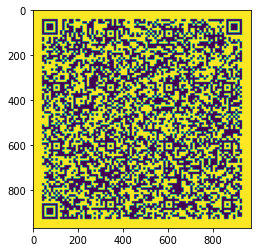

In [27]:
img = qrcode.make(payload)
_ = imshow(np.asarray(img))

### Decode and verify the cose message

Here we use the public key to verify the signature

In [28]:
public_number = cert.public_key().public_numbers()

In [29]:
cose_msg = CoseMessage.decode(cose_encoded)

In [30]:
cose_msg.phdr[Algorithm] , cose_msg.phdr[KID].hex()

(cose.algorithms.Es256, '54455354')

In [31]:
key_attribute_dict = {
    'KTY': 'EC2',
    'CURVE': 'P_256',
    'ALG': 'ES256',
    'X': public_number.x.to_bytes(32, 'big'),
    'Y': public_number.y.to_bytes(32, 'big')
}
cose_key = CoseKey.from_dict(key_attribute_dict)
cose_msg.key = cose_key
cose_msg.verify_signature()

True

In [32]:
cose_msg

<COSE_Sign1: [{'Algorithm': 'Es256', 'KID': b'TEST'}, {}, b'{"1":' ... (580 B), b'\x9e<\xec~\xd8' ... (64 B)]>